In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import zipfile

with zipfile.ZipFile('/content/drive/My Drive/Images.zip') as z:
  z.extractall('/content/Images')

In [3]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt

In [4]:
lowercase = os.listdir('/content/Images/Images/Lowercase')
uppercase = os.listdir('/content/Images/Images/Uppercase')

In [5]:
len(lowercase)

71

In [6]:
len(uppercase)

42

In [7]:
try:
  for id in lowercase:
    if(id=='.DS_Store'):
      continue
    os.makedirs(os.path.join('/tmp/data/training/','l_'+'{}'.format(id)))
    os.makedirs(os.path.join('/tmp/data/testing/','l_'+'{}'.format(id)))

  for id in uppercase:
    if(id=='.DS_Store'):
      continue
    os.makedirs(os.path.join('/tmp/data/training/','u_'+'{}'.format(id)))
    os.makedirs(os.path.join('/tmp/data/testing/','u_'+'{}'.format(id)))
except OSError:
    pass

In [8]:
from shutil import copyfile
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  img_list = os.listdir(SOURCE)
  random.sample(img_list, len(img_list))
  i=0
    
  while(1):
    if(i<SPLIT_SIZE*len(img_list)):
      img_path = os.path.join(SOURCE,img_list[i])
      if(os.path.getsize(img_path)!=0):
        copyfile(img_path,os.path.join(TRAINING,img_list[i]))
        i+=1
        continue
            
    if(i<len(img_list)):
      img_path = os.path.join(SOURCE,img_list[i])
      if(os.path.getsize(img_path)!=0):
        copyfile(img_path,os.path.join(TESTING, img_list[i]))
        i+=1
        continue
    break
        
        
  
LOWER_SOURCE_DIR = '/content/Images/Images/Lowercase'
UPPER_SOURCE_DIR = '/content/Images/Images/Uppercase'
TRAINING_DIR = '/tmp/data/training/'
TESTING_DIR = '/tmp/data/testing/'

split_size = 0.9
for id in lowercase:
  if(id=='.DS_Store'):
      continue
  try:
    split_data(os.path.join(LOWER_SOURCE_DIR,'{}'.format(id)), os.path.join(TRAINING_DIR,'l_'+'{}'.format(id)), os.path.join(TESTING_DIR,'l_'+'{}'.format(id)), split_size)
  except:
    pass

for id in uppercase:
  if(id=='.DS_Store'):
      continue
  try:
    split_data(os.path.join(UPPER_SOURCE_DIR,'{}'.format(id)), os.path.join(TRAINING_DIR,'u_'+'{}'.format(id)), os.path.join(TESTING_DIR,'u_'+'{}'.format(id)), split_size)
  except:
    pass


In [9]:
len(os.listdir('/tmp/data/training/l_seven'))

423

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,  
        target_size=(32, 32),
        batch_size=32,
        color_mode='grayscale',
        class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator =  validation_datagen.flow_from_directory(TESTING_DIR,
                                                         batch_size=32,
                                                         class_mode  = 'categorical',
                                                         color_mode = 'grayscale',
                                                         target_size = (32, 32))

Found 47797 images belonging to 111 classes.
Found 5255 images belonging to 111 classes.


In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

from keras import layers
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization, ZeroPadding2D, Activation
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [12]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (32,32,1)))
model.add(BatchNormalization(axis = 3))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(axis = 3))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(BatchNormalization(axis = 1))
model.add(Dropout(0.5))
model.add(Dense(111, activation = "softmax"))


optimizer = Adam(learning_rate = 0.001)

model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

lr_scheduler = ReduceLROnPlateau(monitor = 'loss', patience = 1, verbose = 1, factor = 0.1)

early_stopper = EarlyStopping(monitor = 'loss', patience = 12, verbose = 1)

history = model.fit_generator(train_generator, epochs = 20, validation_data=validation_generator, callbacks = [lr_scheduler, early_stopper])

Epoch 1/20
1494/1494 [==============================] - 61s 41ms/step - loss: 0.3496 - accuracy: 0.9080 - val_loss: 0.0107 - val_accuracy: 0.9593
Epoch 2/20
1494/1494 [==============================] - 53s 36ms/step - loss: 0.1608 - accuracy: 0.9547 - val_loss: 0.0727 - val_accuracy: 0.9566
Epoch 3/20
1494/1494 [==============================] - 53s 36ms/step - loss: 0.1301 - accuracy: 0.9642 - val_loss: 5.2476e-04 - val_accuracy: 0.9732
Epoch 4/20
1494/1494 [==============================] - 53s 35ms/step - loss: 0.1216 - accuracy: 0.9670 - val_loss: 1.2908e-05 - val_accuracy: 0.9758
Epoch 5/20
1494/1494 [==============================] - 53s 35ms/step - loss: 0.1004 - accuracy: 0.9716 - val_loss: 0.1674 - val_accuracy: 0.9823
Epoch 6/20
1494/1494 [==============================] - 53s 35ms/step - loss: 0.0867 - accuracy: 0.9760 - val_loss: 3.0379e-05 - val_accuracy: 0.9823
Epoch 7/20
1494/1494 [==============================] - 53s 35ms/step - loss: 0.0775 - accuracy: 0.9785 - val_lo

In [14]:
model.save("all_sym_model.h5")

In [15]:
labels = (train_generator.class_indices)

In [16]:
labels

{'l_a': 0,
 'l_alpha': 1,
 'l_b': 2,
 'l_beta': 3,
 'l_c': 4,
 'l_d': 5,
 'l_delta': 6,
 'l_e': 7,
 'l_epsilon': 8,
 'l_eta': 9,
 'l_f': 10,
 'l_five': 11,
 'l_four': 12,
 'l_g': 13,
 'l_gamma': 14,
 'l_h': 15,
 'l_i': 16,
 'l_infty': 17,
 'l_iota': 18,
 'l_j': 19,
 'l_k': 20,
 'l_kappa': 21,
 'l_l': 22,
 'l_lambda': 23,
 'l_lceil': 24,
 'l_lfloor': 25,
 'l_llcorner': 26,
 'l_m': 27,
 'l_minus': 28,
 'l_mu': 29,
 'l_n': 30,
 'l_nabla': 31,
 'l_nine': 32,
 'l_nu': 33,
 'l_o': 34,
 'l_omega': 35,
 'l_one': 36,
 'l_p': 37,
 'l_partial': 38,
 'l_phi': 39,
 'l_pi': 40,
 'l_plus': 41,
 'l_prime': 42,
 'l_psi': 43,
 'l_q': 44,
 'l_r': 45,
 'l_rangle': 46,
 'l_rceil': 47,
 'l_rfloor': 48,
 'l_rho': 49,
 'l_s': 50,
 'l_section': 51,
 'l_seven': 52,
 'l_sigma': 53,
 'l_six': 54,
 'l_t': 55,
 'l_tau': 56,
 'l_theta': 57,
 'l_three': 58,
 'l_times': 59,
 'l_two': 60,
 'l_u': 61,
 'l_v': 62,
 'l_varphi': 63,
 'l_w': 64,
 'l_x': 65,
 'l_y': 66,
 'l_z': 67,
 'l_zero': 68,
 'l_zeta': 69,
 'u_A': 70,
 

In [17]:
index_to_labels = dict((v,k) for k,v in labels.items())

In [46]:
import json

with open('mappings.json', 'w') as fp:
    json.dump(index_to_labels, fp)

In [53]:
with open('mappings.json', 'r') as fp:
    mappings = json.load(fp)

In [48]:
from PIL import Image
import cv2

In [49]:
test_img_path = '/content/Images/Images/Lowercase/x/0.png'

In [40]:
test_img = Image.open(test_img_path)
test_img = test_img.convert('L')
test_img = np.expand_dims(test_img, 2)
test_img = cv2.resize(test_img,(32,32))

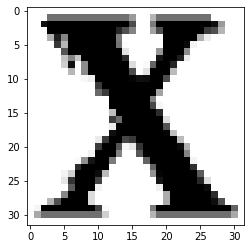

In [41]:
img = np.array(test_img)
plt.imshow(img, cmap = 'gray')
plt.show()

In [42]:
test_img = np.expand_dims(test_img, 2)

In [43]:
test = np.zeros((1, 32, 32, 1), dtype = np.uint8)

In [44]:
test[0] = test_img

In [54]:
mappings[str(np.argmax(model.predict(test)))]

'l_x'